In [59]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 912.8 kB/s eta 0:00:00


In [49]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.9 MB/s eta 0:00:00


In [122]:
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import optuna
from optuna.exceptions import TrialPruned
%matplotlib inline
sns.set()
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
import joblib

In [5]:
df = pd.read_csv('/content/home-listings-example.csv')

<Axes: xlabel='CountyOrParish', ylabel='count'>

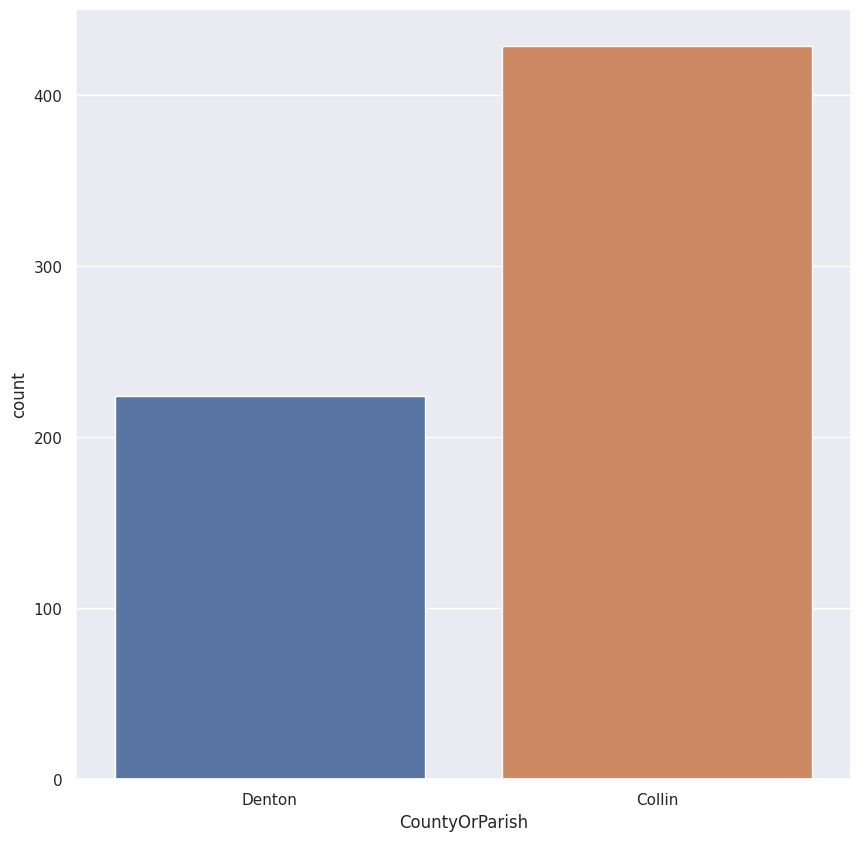

In [89]:
sns.countplot(df, x="CountyOrParish")

<Axes: xlabel='TransactionType', ylabel='count'>

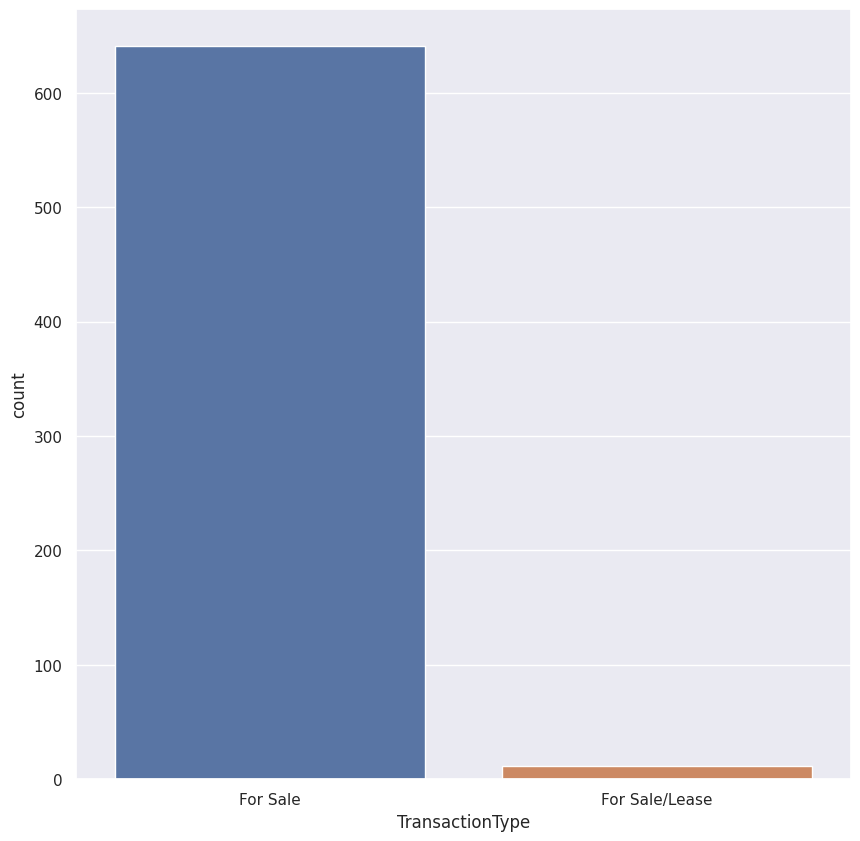

In [90]:
sns.countplot(df, x="TransactionType")

In [7]:
df.shape

(653, 250)

In [ ]:
## There are 430 properties without close price, weren't they sold?

In [8]:
df[df['ClosePrice'].isnull()].shape[0]

430

In [10]:
df[df['ClosePrice'].isnull()].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 429
Data columns (total 250 columns):
 #    Column                                 Dtype  
---   ------                                 -----  
 0    NumberOfTanksAndPonds                  float64
 1    ListingFinancing                       object 
 2    AccessoryUnitType                      object 
 3    AccessoryUnitYN                        object 
 4    AcresBottomLand                        float64
 5    AcresCultivated                        float64
 6    AcresIrrigated                         float64
 7    AcresPasture                           float64
 8    AGExemptionYN                          float64
 9    AppFeePayableTo                        float64
 10   AppFeePlus18YrsYN                      float64
 11   ApplicationFeeAmount                   float64
 12   AppointmentCall                        object 
 13   AppointmentPhone                       object 
 14   AppraiserName                          o

In [54]:
df[~df['ClosePrice'].isnull()][['ClosePrice','BathsTotal','BedsTotal','CDOM','LotSizeAreaSQFT','SqFtTotal','ElementarySchoolName']].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,ClosePrice,BathsTotal,BedsTotal,CDOM,LotSizeAreaSQFT,SqFtTotal
count,223,223,223,223,223,223
mean,427326,2.86637,3.8296,81.3184,7775.75,2932.55
std,197382,0.882813,0.77554,87.7179,4160.05,1084.85
min,185000,1.1,1,-62,0,884
25%,300000,2,3,14.5,6098.4,2062.5
50%,373000,3,4,53,7405.2,2760
75%,480500,3.2,4,117,9125.82,3610
max,1.6225e+06,5.2,5,488,40423.7,7891


In [12]:
df.duplicated().any()

False

In [ ]:
## Why are the numerical features CDOM and DOM having negative values?

In [44]:
pd.set_option('display.max_rows', None)
df[~df['ClosePrice'].isnull()].select_dtypes(exclude='object').lt(0).any()

NumberOfTanksAndPonds                    False
AcresBottomLand                          False
AcresCultivated                          False
AcresIrrigated                           False
AcresPasture                             False
AGExemptionYN                            False
AppFeePayableTo                          False
AppFeePlus18YrsYN                        False
ApplicationFeeAmount                     False
Barn1Length                              False
Barn1Width                               False
Barn2Length                              False
Barn2Width                               False
Barn3Length                              False
Barn3Width                               False
BathsFull                                False
BathsHalf                                False
BathsTotal                               False
BedroomBathroomFeatures                  False
BedsTotal                                False
BuildingNumber                           False
Capitalizatio

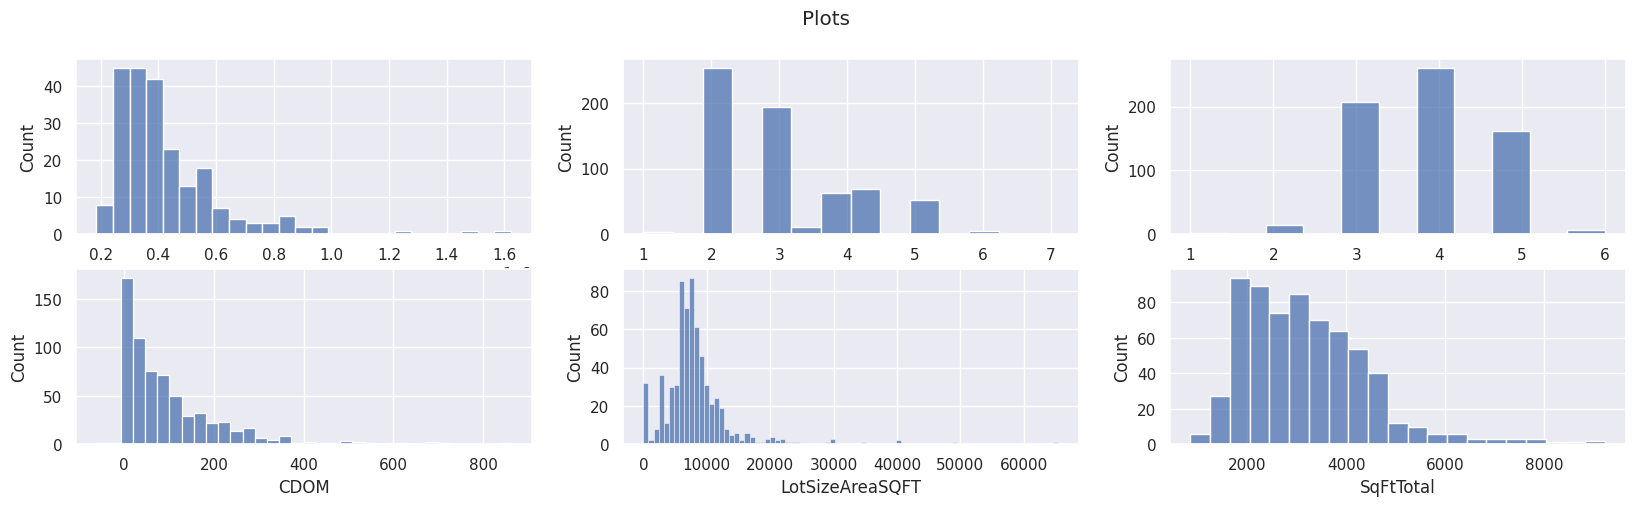

In [55]:
fig, axes = plt.subplots(2, 3, sharex=False,sharey=False, figsize=(20,5))
fig.suptitle('Plots')
sns.histplot(ax=axes[0][0], x=df['ClosePrice'])

sns.histplot(ax=axes[0][1],  x=df['BathsTotal'])

sns.histplot(ax=axes[0][2],  x=df['BedsTotal'])

sns.histplot(ax=axes[1][0],  x=df['CDOM'])

sns.histplot(ax=axes[1][1],  x=df['LotSizeAreaSQFT'])

sns.histplot(ax=axes[1][2],  x=df['SqFtTotal'])

plt.show()

In [152]:
## Why is the numerical features LotSizeAreaSQFT having 0 values?
df[df['LotSizeAreaSQFT']==0]

,NumberOfTanksAndPonds,ListingFinancing,AccessoryUnitType,AccessoryUnitYN,AcresBottomLand,AcresCultivated,AcresIrrigated,AcresPasture,AGExemptionYN,AppFeePayableTo,AppFeePlus18YrsYN,ApplicationFeeAmount,AppointmentCall,AppointmentPhone,AppraiserName,Barn1Length,Barn1Width,Barn2Length,Barn2Width,Barn3Length,Barn3Width,BathsFull,BathsHalf,BathsTotal,BedroomBathroomFeatures,BedsTotal,Block,BuildingNumber,BuyersAgencyCommission,CancelledDate,CapitalizationRate,CDOM,City,CloseDate,ClosePrice,CommunityFeatures,CompensationPaid,ComplexName,ConditionalDate,ConsentforVisitorstoRecord,ConstructionMaterials,YearBuiltDetails,Country,CountyOrParish,CropRetireProgramYN,Crops,CurrentPrice,DateAvailable,DepositAmount,DepositPet,Development,DOCBOX_GUID,DOM,Easements,ElementarySchoolName,Equity,Exclusions,ExpirationDate,ExpirationDateOption,ExteriorFeatures,FencedYardYN,FHA_VA_ApprovedComplexNumber,FinancingApproved,FireplaceFeatures,FireplacesTotal,FloorLocationNumber,Flooring,FoundationDetails,FurnishedYN,GarageLength,GarageWidth,GreenBuildingCertification,GrossAnnualIncome,HandicapYN,HasDocBoxYN,Heating,HighSchoolName,AssociationType,AssociationFeeFrequency,AssociationFee,AssociationFeeIncludes,HOAManagementCompany,HOAManagementCompanyPhone,StructuralStyle,IDXOptInYN,IncludeSlideshowYN,InsuranceExpense,IntermediateSchoolName,IntraOfficeRemarks,JuniorHighSchoolName,KeyboxNumber,KeyBoxType,OtherEquipment,LakeName,LandLeasedYN,LaundryLocation,LeaseConditions,LeasePrice,LeaseTerms,LeaseType,LeasedDate,LenderName,CoListAgentFullName,CoListAgentMLSID,ListAgentDirectWorkPhone,ListAgentFullName,ListAgentMLSID,ListOfficeMLSID,ListOfficeName,ListOfficePhone,ListPrice,ListPriceLow,ListingAgreement,ListingContractDate,Loan1Amount,Loan1InterestRate,Loan1Years,Loan2Amount,Loan2InterestRate,Loan2Years,LoanBalance,LoanInterestRate,LoanPaymentType,LoanType,LotFeatures,LotSizeArea,LotSizeDimensions,LotSizeSource,LotSizeAreaSQFT,LotSizeUnits,LotSize,MiddleSchoolName,MLSAreaMajor,MLSNumber,MLSNumberSaleOrLease,MLSAreaMinor,MortgageCompany,MunicipalUtilityDistrictYN,NoticeSurveillanceDevicesPresent,NumberOfBarns,NumberOfDiningAreas,NumberOfLakes,NumberOfLivingAreas,NumberOfLots,NumberOfParkingSpaces,NumberOfPetsAllowed,NumberOfResidences,NumberOfStories,NumberOfStoriesInBuilding,NumberOfUnits,NumberOfVehicles,NumberOfWells,Occupancy,OffMarketDate,OfficeSupervisor,OfficeSupervisorLicense,OfficeSupervisorPhone,OpenHouseUpcoming,OriginalListPrice,OwnerName,OwnerPermissionToVideoYN,ParcelNumber,ParcelNumber2,ParkingFeatures,ParkingSpacesCarport,ParkingSpacesCoveredTotal,ParkingSpacesGarage,PendingDate,PetPolicy,PetsYN,PhotoCount,PlannedDevelopment,PoolYN,PoolFeatures,Possession,PossibleShortSaleYN,PostalCodePlus4,TitleCompanyPreferred,PresentUse,Unnamed: 179,PrimarySchoolName,PrivateRemarks,PublicRemarks,PropertySubType,PropertyType,FinancingProposed,ProposedUse,Directions,RanchName,RanchType,RATIO_ClosePrice_By_ListPrice,RATIO_ClosePrice_By_OriginalListPrice,RATIO_CurrentPrice_By_Acres,RATIO_CurrentPrice_By_LotSizeAreaSQFT,RATIO_CurrentPrice_By_SQFT,RATIO_CurrentPrice_By_SQFTBuilding,Restrictions,RoadFrontage,Roof,SchoolDistrict,SecondMortgageYN,SecurityFeatures,SecuritySystemYN,SellerContributions,SellerType,SellingAgent2,SellingAgentDirectWorkPhone,SellingAgentFullName,SellingAgentMLSID,SellingAgentSupervisor,SellingOfficeMLSID,SellingOfficeName,SellingOfficePhone,SeniorHighSchoolName,ShowingInstructions,ShowingInstructionsType,SmartHomeFeaturesApporPassYN,SoilType,SoldTerms,SpecialNotes,SQFTBuilding,SQFTGross,SqFtTotal,BuildingAreaSource,StateOrProvince,Status,StatusChangeTimestamp,StreetDirPrefix,StreetDirSuffix,StreetName,StreetNumber,StreetSuffix,ArchitecturalStyle,SubAgencyCommission,SubdividedYN,SubdivisionName,TaxLegalDescription,TempOffMarketDate,ThirdPartyAssistanceProgramYN,TitleCompanyClosing,TitleCompanyLocation,TitleCompanyPhone,Topography,TransactionType,UnexemptTaxes,UnitNumber,Utilities,UtilitiesOther,VariableFeeYN,WasherDryerConnections
35,NaN,Na

<ipython-input-58-dc7b8dd79534>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[['ClosePrice','BathsTotal','BedsTotal','CDOM','LotSizeAreaSQFT','SqFtTotal','ElementarySchoolName']].corr()


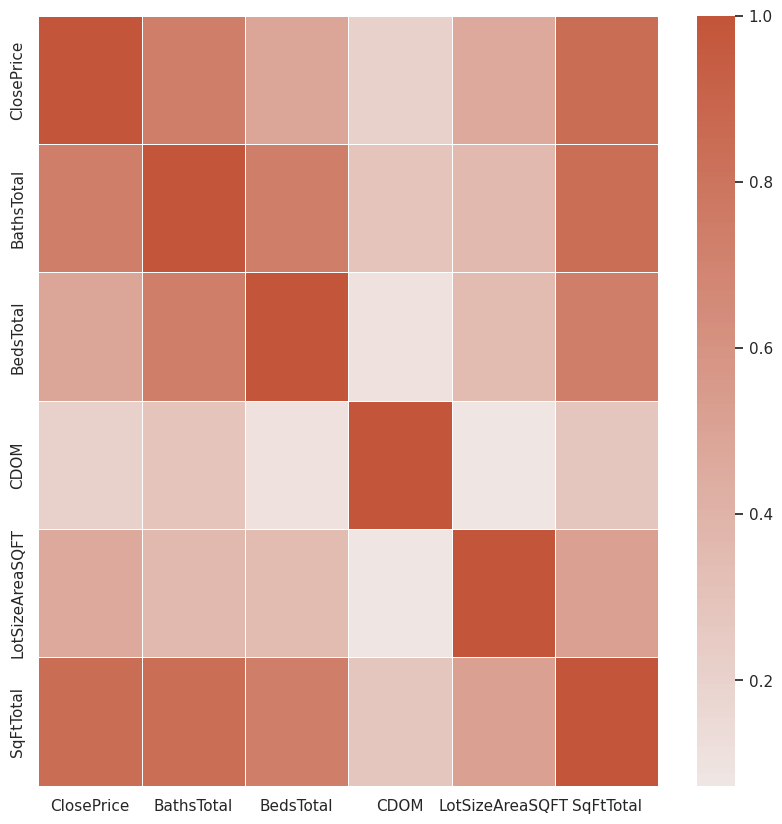

In [58]:
corr = df[['ClosePrice','BathsTotal','BedsTotal','CDOM','LotSizeAreaSQFT','SqFtTotal','ElementarySchoolName']].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,  cmap=cmap, center=0,square=False,linewidths=.5 )
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

In [61]:
df_analisis = df[~df['ClosePrice'].isnull()].select_dtypes(exclude='object')

In [63]:
X_bo = df_analisis.drop(columns='ClosePrice').replace([np.inf, -np.inf], np.nan).fillna(-9999)
y_bo = df_analisis['ClosePrice'].copy()

In [72]:
clf_rf = RandomForestRegressor(n_jobs = 7, min_samples_leaf = round(X_bo.shape[0]*0.01))
feat_selector = BorutaPy(clf_rf, n_estimators='auto', verbose=2, random_state=14)
feat_selector.fit(X_bo.values, y_bo.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	122
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	109
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	7
Rejected: 	109
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	7
Rejected: 	109
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	7
Rejected: 	109
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	109
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	109
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	109
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	6
Rejected: 	109
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	4

BorutaPy(estimator=RandomForestRegressor(min_samples_leaf=2, n_estimators=44,
                                         n_jobs=7,
                                         random_state=RandomState(MT19937) at 0x79E793CEFB40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x79E793CEFB40, verbose=2)

In [74]:
df_bo = pd.DataFrame({'feature':df_analisis.drop(columns='ClosePrice').columns, 'accepted':feat_selector.support_, 'weak':feat_selector.support_weak_, 'ranking':feat_selector.ranking_})

In [75]:
df_bo[df_bo['accepted'] | df_bo['weak']]

,feature,accepted,weak,ranking
28,CurrentPrice,True,False,1
55,CoListAgentMLSID,True,False,1
57,ListPrice,True,False,1
67,LotSizeArea,True,False,1
69,LotSizeAreaSQFT,True,False,1
86,OriginalListPrice,True,False,1
104,RATIO_CurrentPrice_By_SQFT,False,True,2
114,SqFtTotal,True,False,1
117,UnexemptTaxes,False,True,2


In [ ]:
#TO DO: understand more about the dataset and it's features
#Understand outliers
#Understand if the same house appears more than one time with different features(like de price)